# Amath 584 Homework 2
## Eigenfaces, PCA, and SVD
#### Michael Kupperman
This notebook contains all of the code snippets for homework 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import os
import scipy
import imageio

Import the cropped data. (Data is already unzipped)

In [2]:
cropped_dir = 'Data/CroppedYale/yaleB'
cropped_files = []
for idx in range(1,40):
    tmp = ''
    if idx < 10:
        tmp = '0'
    tmp += str(idx)
    crop_dir = cropped_dir + tmp
    if not os.path.isdir(crop_dir):
        continue
    cropped_files.append([])
    for im in [file for file in os.listdir(crop_dir) if os.path.isfile(os.path.join(crop_dir, file))]:
        #print(im[-1])
        if im[-1] != 'd':
            cropped_files[-1].append((imageio.imread(os.path.join(crop_dir, im))) / 255)
        else:
            pass
            #print(im)
people_vectors = []
for person in cropped_files:
    flat = []
    for im in person:
        flat.append(im.reshape(im.shape[0] * im.shape[1]))
    people_vectors.append(np.stack(flat, axis=1))
A = np.concatenate(people_vectors, axis=1)
target_shape = cropped_files[0][0].shape

Import the uncropped images

In [3]:
uc_images = []
uncrop_path = 'Data/UncroppedYale/'
for file in [file for file in os.listdir(uncrop_path) if os.path.isfile(os.path.join(uncrop_path, file))]:
    #print(file)
    uc_images.append(imageio.imread(os.path.join(uncrop_path, file))/1)
uncrop_target_shape = uc_images[0].shape
for idx in range(len(uc_images)):
    tmp = uc_images[idx].shape
    uc_images[idx] = uc_images[idx].reshape(tmp[0]*tmp[1])
    


In [4]:
#Collect the data vectors into a matrix
A = np.concatenate(people_vectors, axis=1)
B = np.stack(uc_images, axis=1)
A_avg = np.average(A, axis=1)[:, np.newaxis]
A = A - A_avg
A_split = A[:,-200:]
A = A[:, 0:-200]
B_avg = np.average(B, axis=1)[:, np.newaxis]
B = B - B_avg
B_split = B[:, -20:]
B = B[:, 0:-20]

In [5]:
print(A.shape, B.shape) # Check the matrix shapes

(32256, 2214) (77760, 145)


In [6]:
%%time
[U, S, V] = np.linalg.svd(A, full_matrices=False)
# Warning: slow block


CPU times: user 45.8 s, sys: 4.29 s, total: 50.1 s
Wall time: 3.4 s


In [7]:
print(U.shape, S.shape, V.shape)

(32256, 2214) (2214,) (2214, 2214)


In [8]:
%%time
[Uc, Sc, Vc] = np.linalg.svd(B, full_matrices=False)

CPU times: user 1.94 s, sys: 289 ms, total: 2.23 s
Wall time: 144 ms


In [9]:
print(Uc.shape, Sc.shape, Vc.shape)

(77760, 145) (145,) (145, 145)


In [10]:
Sm = np.diag(S)

## Goodness of Fit

Let's look at the singular value distribution

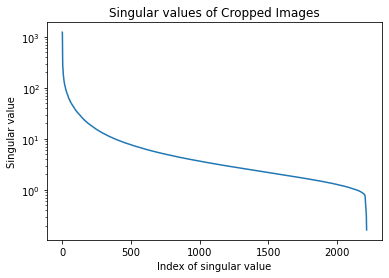

In [12]:
plt.plot(1+np.arange(S.shape[0]), S)
plt.yscale("log")
plt.ylabel('Singular value')
plt.xlabel('Index of singular value')
plt.title('Singular values of Cropped Images')
plt.savefig('Figures/Fig2.eps')
plt.show()

In [17]:
# Check how many singular values needed to recover most of the energy in the singular value distribution
for thold in [0.9, 0.95, 0.99]:  # Different energy recovery levels
    print(thold, np.min(np.where(np.cumsum(S*S)/np.sum(S*S)> thold))+1)


0.9 23
0.95 61
0.99 287


In [18]:
idx = 287
sq = S
perc = np.sum(np.square(sq[0:idx])) / np.sum(np.square(sq))
print(perc)

0.9900231929051452


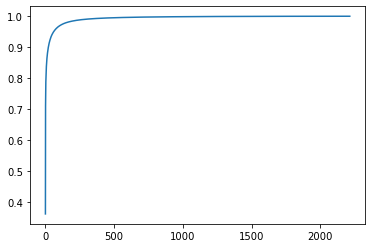

In [19]:
cumsum_sv = np.cumsum(S*S)/np.sum(S*S)
plt.plot(cumsum_sv)

### Eigenfaces of Cropped Data

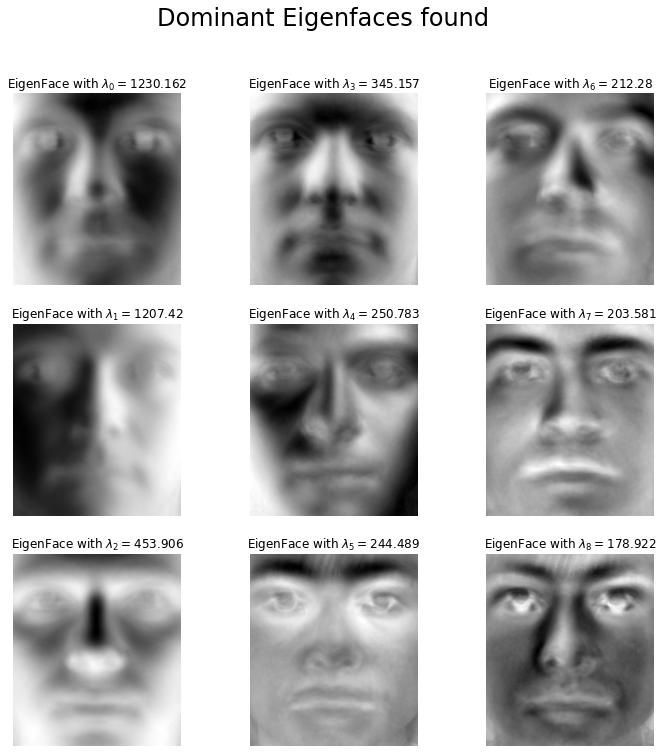

In [20]:
fig, ax = plt.subplots(3,3, figsize=(12,12))
col = -1
for idx in range(9):
    if idx % 3 == 0:
        col += 1
    row = idx % 3
    ax[row][col].imshow(U[:, idx].reshape(target_shape), cmap='gray')
    ax[row][col].set_title(f'EigenFace with $\lambda_{idx}=$' + str(S[idx].round(3)))
    ax[row][col].axis('off')
    #plt.show()
    #print(S[idx])
#plt.savefig('./Figures/Fig1.png', dpi=900)
fig.suptitle('Dominant Eigenfaces found', fontsize=24)
plt.show()


Compute the reconstruction on the validation split using `idx=287` singular values.

In [21]:
idx = 23
nsig = idx
Uadj = U[:,0:idx]# @ np.diag(S[0:idx])
newface = A_avg + (Uadj @ np.asmatrix(Uadj).H  @ A_split)
print('newface has shape:', newface.shape)

newface has shape: (32256, 200)


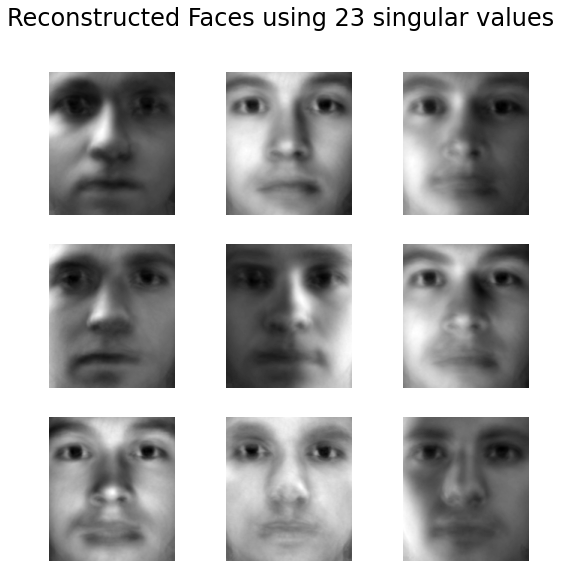

In [22]:
fig, ax = plt.subplots(3,3, figsize=(9,9))
col = -1
for idx in range(9):
    if idx % 3 == 0:
        col += 1
    row = idx % 3
    ax[row][col].imshow((newface+A_avg)[:,idx].reshape(target_shape), cmap='gray')
    ax[row][col].axis('off')
fig.suptitle(f'Reconstructed Faces using {nsig} singular values', fontsize=24)
plt.savefig('./Figures/Fig11.png', dpi=900)
plt.show()

In [23]:
idx = 61
nsig = idx
recon_idx = U[:,0:idx] @ np.diag(S[0:idx])  @V[0:idx,:]
#plt.imshow(recon_idx[:,0].reshape(target_shape), cmap='gray')
#plt.show()

Uadj = U[:,0:idx]# @ np.diag(S[0:idx])
newface = A_avg + (Uadj @ np.asmatrix(Uadj).H  @ A_split)
print('newface has shape:', newface.shape)
#plt.imshow(newface)
#plt.show()

newface has shape: (32256, 200)


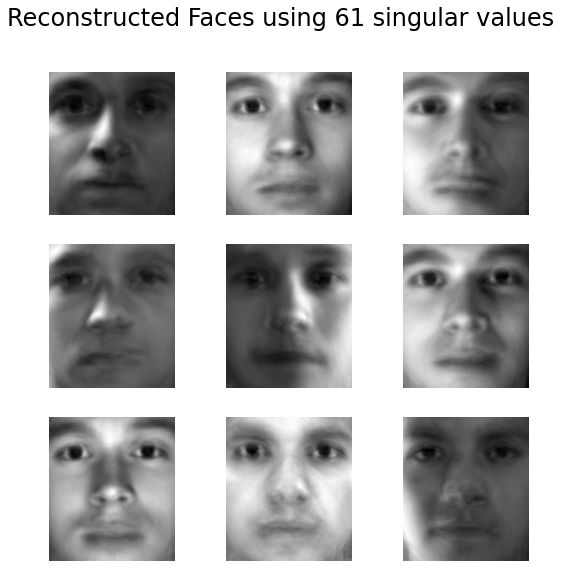

In [24]:
fig, ax = plt.subplots(3,3, figsize=(9,9))
col = -1
for idx in range(9):
    if idx % 3 == 0:
        col += 1
    row = idx % 3
    ax[row][col].imshow((newface+A_avg)[:,idx].reshape(target_shape), cmap='gray')
    ax[row][col].axis('off')
fig.suptitle(f'Reconstructed Faces using {nsig} singular values', fontsize=24)
plt.savefig('./Figures/Fig8.png', dpi=900)
plt.show()

Compute the reconstruction on the validation split using `idx=287` singular values.

In [25]:
idx = 287
nsig = 287
recon_idx = U[:,0:idx] @ np.diag(S[0:idx])  @V[0:idx,:]
#plt.imshow(recon_idx[:,0].reshape(target_shape), cmap='gray')
#plt.show()

Uadj = U[:,0:idx]# @ np.diag(S[0:idx])
newface = A_avg + (Uadj @ np.asmatrix(Uadj).H  @ A_split)
print('newface has shape:', newface.shape)
#plt.imshow(newface)
#plt.show()

newface has shape: (32256, 200)


### Sample eigenfaces of validation split (1 person, 9 lighting conditions)

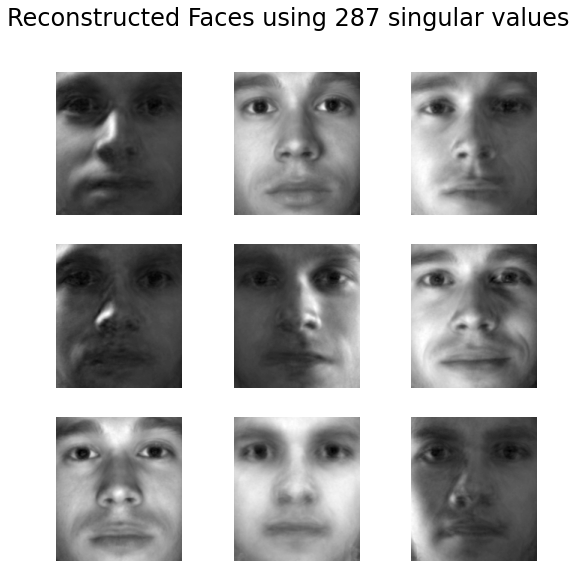

In [26]:
fig, ax = plt.subplots(3,3, figsize=(9,9))
col = -1
for idx in range(9):
    if idx % 3 == 0:
        col += 1
    row = idx % 3
    ax[row][col].imshow((newface+A_avg)[:,idx].reshape(target_shape), cmap='gray')
    ax[row][col].axis('off')
fig.suptitle(f'Reconstructed Faces using {nsig} singular values', fontsize=24)
plt.savefig('./Figures/Fig9.png', dpi=900)
plt.show()

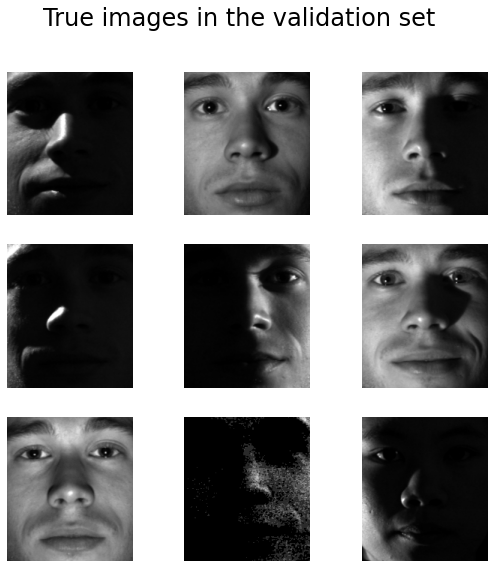

In [27]:
fig, ax = plt.subplots(3,3, figsize=(9,9))
col = -1
for idx in range(9):
    if idx % 3 == 0:
        col += 1
    row = idx % 3
    ax[row][col].imshow((A_split+A_avg)[:, idx].reshape(target_shape), cmap='gray')
    ax[row][col].axis('off')

fig.suptitle('True images in the validation set', fontsize=24)
plt.savefig('./Figures/Fig10.png', dpi=900)
plt.show()

### Reconstructions in Validation Set
These look very good, with many less singular values required.

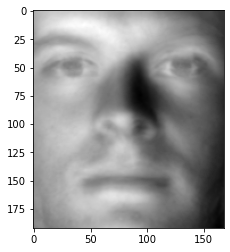

In [28]:
idx = 17
recon_idx = U[:,0:idx] @ np.diag(S[0:idx])  @V[0:idx,:]
plt.imshow(recon_idx[:,0].reshape(target_shape), cmap='gray')
plt.show()

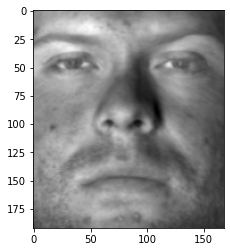

In [29]:
idx = 290
recon_idx = U[:,0:idx] @ np.diag(S[0:idx])  @V[0:idx,:]
plt.imshow(recon_idx[:,0].reshape(target_shape), cmap='gray')
plt.show()
q1 = recon_idx[:,0].reshape(target_shape)

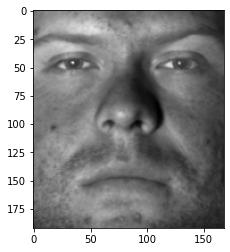

In [30]:
# Let's have a look at a very accurate reconstruction
idx = 2000
recon_idx = U[:,0:idx] @ np.diag(S[0:idx])  @V[0:idx,:]
plt.imshow(recon_idx[:,0].reshape(target_shape), cmap='gray')
plt.show()
q2 = recon_idx[:,0].reshape(target_shape)

In [31]:
S[-1]  # smallest singular value

0.16386545438348907

In [32]:
S[-5:-1]

array([0.41378173, 0.3707933 , 0.31961794, 0.23281161])

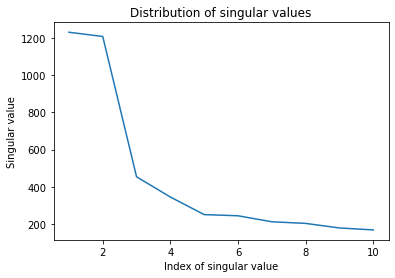

In [33]:
first = 10
plt.plot(np.arange(first)+1, S[0:first])
#plt.yscale("log")
plt.ylabel('Singular value')
plt.xlabel('Index of singular value')
plt.title('Distribution of singular values')
plt.savefig('Figures/Fig3.eps')
plt.show()

The first three eigenvalues contain the most information common to all faces, as is captured with their significantly larger singular values. 

# Uncropped Images

[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]] [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


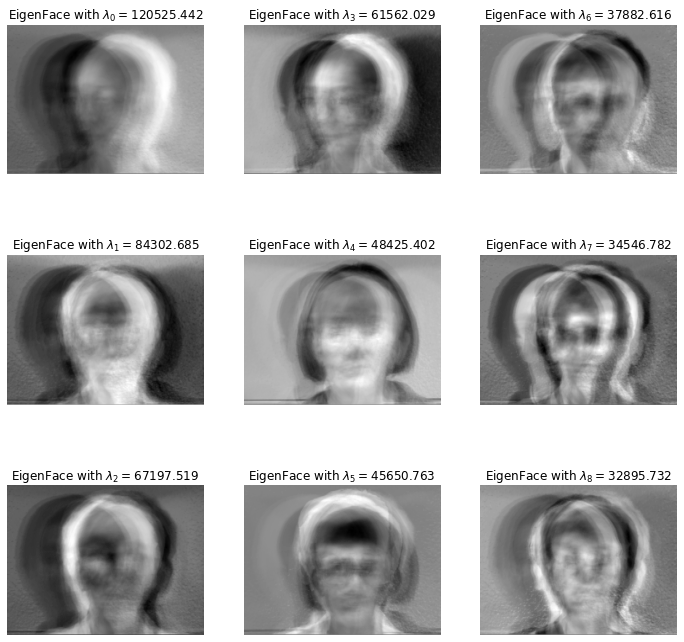

In [34]:
fig, ax = plt.subplots(3,3, figsize=(12,12))
print(ax, ax[0])
col = -1
for idx in range(9):
    if idx % 3 == 0:
        col += 1
    #print(idx, col)
    row = idx % 3
    ax[row][col].imshow(Uc[:, idx].reshape(uncrop_target_shape), cmap='gray')
    ax[row][col].set_title(f'EigenFace with $\lambda_{idx}=$' + str(Sc[idx].round(3)))
    ax[row][col].axis('off')
    #plt.show()
    #print(S[idx])
plt.savefig('./Figures/Fig5.png', dpi=900)
plt.show()


In [35]:
# Check how many singular values needed to recover most of the energy in the singular value distribution
for thold in [0.9, 0.95, 0.99]:  # Different energy recovery levels
    print(thold, np.min(np.where(np.cumsum(Sc*Sc)/np.sum(Sc*Sc)> thold))+1)


0.9 25
0.95 47
0.99 97


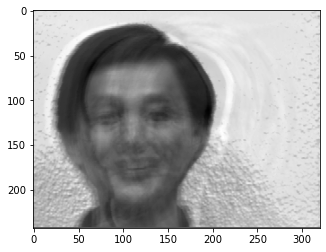

In [31]:
# Let's have a look at a low dimensional accurate reconstruction
idx = 25
person = 30
recon_idx =B_avg + Uc[:,0:idx] @ np.diag(Sc[0:idx])  @Vc[0:idx,:]
plt.imshow(recon_idx[:,person].reshape(uncrop_target_shape), cmap='gray')
plt.show()

In [36]:
idx = 2
nsig = idx
indiv = 1
Uadj = Uc[:,0:idx]# @ np.diag(S[0:idx])
newface = B_avg + (np.asmatrix(Uadj) @ (np.asmatrix(Uadj).H * np.asmatrix(B_split[:,indiv]).T))
print('newface has shape:', newface.shape)
#plt.imshow(newface)
#plt.show()

newface has shape: (77760, 1)


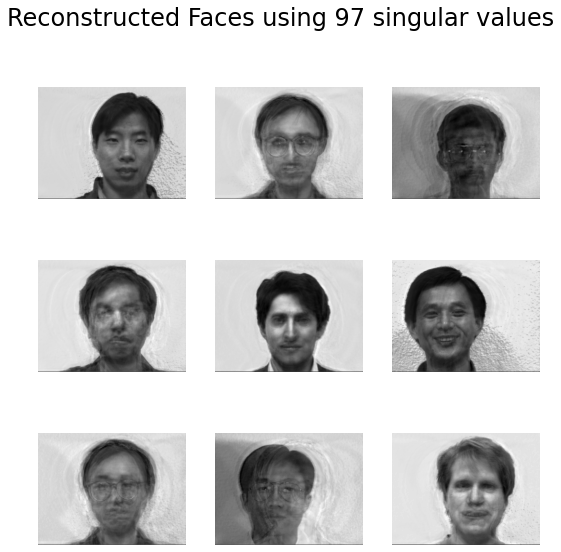

In [40]:
fig, ax = plt.subplots(3,3, figsize=(9,9))
col = -1
nsig = 97
for idx in range(9):
    if idx % 3 == 0:
        col += 1
    row = idx % 3
    indiv = 1
    Uadj = Uc[:,0:nsig]# @ np.diag(S[0:idx])
    newface = B_avg + (np.asmatrix(Uadj) @ (np.asmatrix(Uadj).H * np.asmatrix(B_split[:,idx]).T))

    ax[row][col].imshow(newface.reshape(uncrop_target_shape), cmap='gray')
    ax[row][col].axis('off')
fig.suptitle(f'Reconstructed Faces using {nsig} singular values', fontsize=24)
plt.savefig('./Figures/Fig13.png', dpi=900)
plt.show()

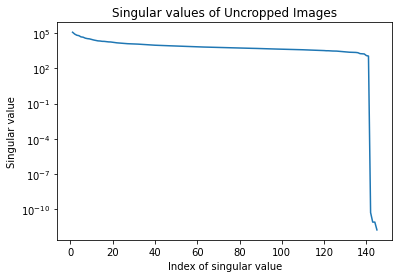

In [41]:
plt.plot(1+np.arange(Sc.shape[0]), Sc)
plt.yscale("log")
plt.ylabel('Singular value')
plt.xlabel('Index of singular value')
plt.title('Singular values of Uncropped Images')
plt.savefig('Figures/Fig4.eps')
plt.show()

In [42]:
Sc[-10:]

array([2.17963458e+03, 1.82188235e+03, 1.76654485e+03, 1.71147741e+03,
       1.24084420e+03, 1.13088712e+03, 5.35240482e-11, 8.22432599e-12,
       8.22432599e-12, 1.77663138e-12])

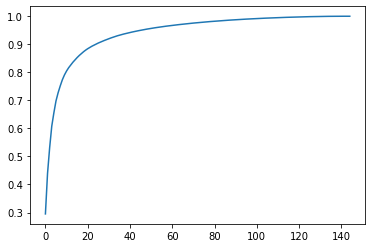

In [43]:
cumsum_svc = np.cumsum(Sc*Sc)/np.sum(Sc*Sc)
plt.plot(cumsum_svc)